# World Models
**Jin Yeom**  
jin.yeom@hudl.com

In [1]:
from collections import namedtuple
from pprint import pprint

import gym
from gym.spaces import Box
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import animation as anime
from IPython.display import HTML
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F
from torch.utils import data
from torchvision.utils import make_grid
from tqdm import tqdm_notebook as tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cpu


## Environment

We'll start with something simple: **Atari 2600 Pong**.

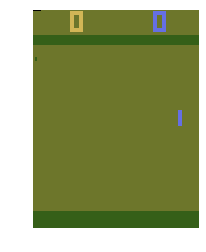

In [3]:
env = gym.make('PongNoFrameskip-v4')
obs = env.reset()
plt.imshow(obs)
plt.axis('off')
plt.show()

Before we start working with the environment, we'll preprocess the observation a little bit. Particularly, I think the scoreboard on top of the screen is rather irrelevant, so we'll crop it out; same for the bottom block.

In [4]:
class ProcessFrame(gym.ObservationWrapper):
    def __init__(self, env, size):
        super(ProcessFrame, self).__init__(env)
        self.size = size
        self.observation_space = Box(low=0, high=1, shape=(3, size, size), dtype=np.float32)

    def observation(self, obs):
        obs = Image.fromarray(obs[34:194, :160, :])  # crop the center square
        obs = np.array(obs.resize((self.size, self.size), resample=Image.BILINEAR))
        return (obs.astype(np.float32) / 255.0).transpose(2, 0, 1)

We'll also apply frame skip to increase performance ([Braylan et al., 2015](http://nn.cs.utexas.edu/downloads/papers/braylan.aaai15.pdf)).

In [5]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, frame_skip):
        super(FrameSkip, self).__init__(env)
        self._frame_skip = frame_skip

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._frame_skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

    def reset(self):
        return self.env.reset()

Lastly, we have to ensure that the environment takes one hot actions, rather than scalars. This is simply because our controller takes one hot vectors as a part of its inputs.

In [6]:
class OneHotAction(gym.ActionWrapper):
    def __init__(self, env):
        super(OneHotAction, self).__init__(env)
        n = env.action_space.n
        self.action_space = Box(low=0, high=1, shape=(n,), dtype=np.float32)
        
    def action(self, action):
        return np.argmax(action, axis=-1)

Now, we can compile these wrappers together with `gym.make` to make a single `make_pong` function. Nothing important, just neat to have!

In [7]:
def make_pong():
    env = gym.make('PongNoFrameskip-v4')
    env = ProcessFrame(env, 64)
    env = FrameSkip(env, 4)
    env = OneHotAction(env)
    return env

Let's take a look at observations from our processed environment.

In [8]:
env = make_pong()
fig = plt.figure()
plt.axis('off')
ims = []
obs = env.reset()
for _ in range(64):
    action = env.action_space.sample()
    obs, _, _, _ = env.step(action)
    ims.append([plt.imshow(obs.transpose(1, 2, 0), animated=True)])
anim = anime.ArtistAnimation(fig, ims, interval=25, blit=True)
plt.close()
HTML(anim.to_html5_video())

## VAE (V) model

Our $V$ model will have the same architecture as from the paper.

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)
        self.fc_mean = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        x = F.relu(self.conv3(x), inplace=True)
        x = F.relu(self.conv4(x), inplace=True)
        x = x.view(x.size(0), -1)
        return self.fc_mean(x), self.fc_logvar(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv5 = nn.ConvTranspose2d(32, 3, 5, stride=2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x), inplace=True)
        x = x.view(x.size(0), 1024, 1, 1)
        x = F.relu(self.deconv2(x), inplace=True)
        x = F.relu(self.deconv3(x), inplace=True)
        x = F.relu(self.deconv4(x), inplace=True)
        x = torch.sigmoid(self.deconv5(x))

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        if self.training:
            return self.reparameterize(mu, logvar)
        return mu
        
    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return eps.mul(sigma).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_ = self.decoder(z)
        return mu, logvar, z, x_

## Memory (M) model

This is the exciting part! Our agent's ability to predict the future based on its action is, in fact, the essence of a world model.

In [12]:
class MixtureDensityLSTM(nn.Module):
    def __init__(self, latent_dim, hid_dim, act_dim, num_mixtures=5):
        super(MixtureDensityLSTM, self).__init__()
        self.latent_dim = latent_dim
        self.hid_dim = hid_dim
        self.act_dim = act_dim
        self.lstm = nn.LSTM(latent_dim + act_dim, hid_dim)
        # mixture density network
        self.num_mixtures = num_mixtures
        self.fc_pi = nn.Linear(hid_dim, num_mixtures * self.latent_dim)
        self.fc_mean = nn.Linear(hid_dim, num_mixtures * self.latent_dim)
        self.fc_logvar = nn.Linear(hid_dim, num_mixtures * self.latent_dim)

    def reset(self):
        return (torch.zeros(1, 1, self.hid_dim), torch.zeros(1, 1, self.hid_dim))

    def mixture_coef(self, x):
        pi = F.softmax(self.fc_pi(x).view(x.size(0), -1, self.num_mixtures, self.latent_dim), dim=2)
        mean = self.fc_mean(x).view(x.size(0), -1, self.num_mixtures, self.latent_dim)
        logvar = self.fc_logvar(x).view(x.size(0), -1, self.num_mixtures, self.latent_dim)
        return pi, mean, logvar

    def sample(self, pi, mean, logvar):
        stdev = torch.exp(0.5 * logvar)
        return torch.sum(pi * torch.normal(mean, stdev), dim=2)

    def forward(self, z, a, h, c):
        z = torch.cat([z, a], dim=-1)
        z, (h, c) = self.lstm(z, (h, c))
        return self.mixture_coef(z), (h, c)

## Policy

In [13]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, act_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Linear(state_dim, act_dim)
        self.critic = nn.Linear(state_dim, 1)
    
    def act(self, x):
        pi = F.softmax(self.actor(x), dim=-1)
        dist = distributions.OneHotCategorical(pi)
        return dist.sample()
    
    def value(self, x):
        return self.critic(x).detach()
    
    def forward(self, x):
        pi = F.softmax(self.actor(x), dim=-1)
        dist = distributions.OneHotCategorical(pi)
        action = dist.sample()
        logpi = dist.log_prob(action)
        entropy = dist.entropy()
        return action, logpi, entropy, self.value(x)

## Agent

Now, we can put together an agent! Pay special attention to how the agent makes an action.

In [14]:
latent_dim = 16
hid_dim = 32
act_dim = env.action_space.shape[0]
state_dim = latent_dim + hid_dim * 2

vision = VAE(latent_dim).to(device)
memory = MixtureDensityLSTM(latent_dim, hid_dim, act_dim).to(device)
controller = ActorCritic(state_dim, act_dim).to(device)

Going back to the environment, let's see if our newly born agent can interact with the game.

In [15]:
fig = plt.figure()
plt.axis('off')
ims = []

env = make_pong()
obs = env.reset()
h, c = memory.reset()
h = h.to(device)
c = c.to(device)
for _ in range(64):
    obs = torch.from_numpy(obs).unsqueeze(0).to(device)
    z = vision.encode(obs).unsqueeze(0)
    s = torch.cat([z, h, c], dim=-1)
    a = controller.act(s)
    _, (h, c) = memory(z, a, h, c)
    h = h.detach()
    c = c.detach()
    action = a.squeeze().cpu().numpy()
    obs, reward, done, _ = env.step(action)
    ims.append([plt.imshow(obs.transpose(1, 2, 0), animated=True)])
anim = anime.ArtistAnimation(fig, ims, interval=25, blit=True)
plt.close()
HTML(anim.to_html5_video())

Alright, we can move on to data collection then.

## Data collection

In this section, we let the agent collect the environment data to train its world model. Since we're only interested in transition data ($s_t, a_t, s_{t+1}, a_{t+1}, ...$),

In [16]:
Transition = namedtuple('Transition', ['action', 'obs'])

**Note**: as you can see below, our `TransitionBuffer.reset` takes the first observation, returned by `env.reset()`. This means that each time a transition $\tau_t$ is pushed into the buffer, `transition.obs` is not $o_t$ but $o_{t+1}$.

In [17]:
class TransitionBuffer(data.Dataset):
    def __init__(self, env, capacity):
        self.capacity = capacity
        self.obs = np.zeros((self.capacity+1, *env.observation_space.shape), dtype=np.float32)
        self.action = np.zeros((self.capacity, *env.action_space.shape), dtype=np.float32)
        self._t = 0

    @property
    def full(self):
        return self._t == self.capacity

    def reset(self, obs):
        self.obs.fill(0)
        self.action.fill(0)
        self._t = 0
        self.obs[self._t] = obs

    def push(self, transition):
        assert not self.full
        self.obs[self._t+1] = transition.obs
        self.action[self._t] = transition.action
        self._t += 1
    
    def __getitem__(self, i):
        return self.obs[i], self.action[i]
    
    def __len__(self):
        return self.capacity

In [18]:
class ObservationSampler(data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source))
        for i in range(0, len(indices), self.batch_size):
            batch = []
            for j in indices[i:i+self.batch_size]:
                batch.append(self.data_source[j][0])
            yield torch.from_numpy(np.stack(batch))

    def __len__(self):
        num_data_points = len(self.data_source)
        last = int(num_data_points % self.batch_size > 0)
        return num_data_points // self.batch_size + last

In [19]:
buffer = TransitionBuffer(env, 10000)
sampler = ObservationSampler(buffer, 16)

In [20]:
def explore(env, buffer):
    obs = env.reset()
    buffer.reset(obs)
    h, c = memory.reset()
    h = h.to(device)
    c = c.to(device)
    while not buffer.full:
        obs = torch.from_numpy(obs).unsqueeze(0).to(device)
        z = vision.encode(obs).unsqueeze(0)
        s = torch.cat([z, h, c], dim=-1)
        a = controller.act(s)
        _, (h, c) = memory(z, a, h, c)
        h = h.detach()
        c = c.detach()
        action = a.squeeze().cpu().numpy()
        obs, reward, done, _ = env.step(action)
        buffer.push(Transition(action=action, obs=obs))
        if done:
            obs = env.reset()

In [21]:
explore(env, buffer)

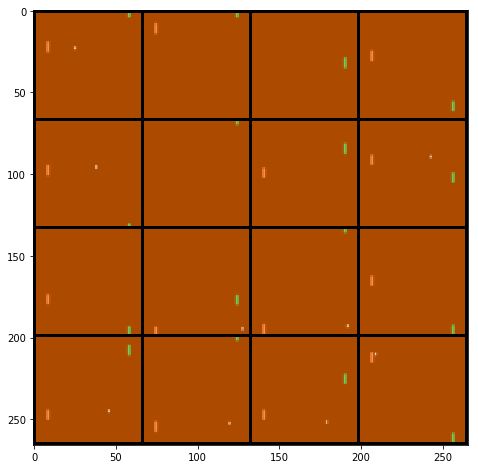

In [22]:
batch = next(iter(sampler))
grid = make_grid(batch, nrow=4, normalize=True).numpy()
plt.figure(figsize=(8, 8))
plt.imshow(grid.transpose(1, 2, 0))
plt.show()

## Training V model

In [23]:
def recon_loss(recon_x, x):
    mse = F.mse_loss(recon_x, x, reduction='none')
    mse = torch.sum(mse.view(mse.size(0), -1), dim=1)
    return torch.mean(mse, dim=0)

In [24]:
def latent_loss(mu, logvar):
    kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    return kld.sum(1).mean(0, True)

In [25]:
optimizer = optim.Adam(params=vision.parameters())

In [26]:
for ep in tqdm(range(10)):
    for i, x in enumerate(tqdm(sampler, leave=False)):
        x = x.to(device)
        mu, logvar, z, x_ = vision(x)
        mse = recon_loss(x_, x)
        kld = latent_loss(mu, logvar)
        loss = mse + kld
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Episode {ep} iter. {i}")
            print(f"MSE = {mse}")
            print(f"KLD = {kld}")
            print(f"loss = {loss}")

TypeError: expected Tensor as element 0 in argument 0, but got NoneType